# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. 
Source code: https://github.com/ocontreras309/ML_Notebooks/blob/master/PMF_Recommender_Systems.ipynb

We didn't replace the vaiable names, therefore in the script the variable "is_listened" is called "ratings" and the "media_id" is "movieId"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/music_recommendation/"
df = pd.read_csv(PATH + 'ratings.csv')
df_join=df.copy()
df.head()

,Unnamed: 0,user_id,media_id,is_listened
0,0,9241,222606,0.0
1,1,16547,250467,1.0
2,2,7665,305197,1.0
3,3,1580,900502,0.0
4,4,1812,542335,1.0


In [ ]:
# for the sake of reproduceability, we set a random_state.
df_join = df_join.sample(frac =0.01,random_state=123) 


In [ ]:
print("Before undersampling: ", Counter(df_join.iloc[:,-1]))

Before undersampling:  Counter({1.0: 9923, 0.0: 4370})


The following cell is for undersampling. To test it: just undo the comment at second last line of code.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
 
X = df_join.iloc[:,:-1]
y = df_join.iloc[:,-1]


# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X, y)

# summarize class distribution
print("After undersampling: ", Counter(y_train_under))

df_Rate=pd.DataFrame(y_train_under, columns=["rating"])
df_ID=pd.DataFrame(X_train_under, columns=["index","userId","movieId"])
#df_join = pd.merge(df_ID, df_Rate, how='inner', left_index=True, right_index=True)
#df_join.head()

After undersampling:  Counter({0.0: 4370, 1.0: 4370})


Let's now prepare our sparse review matrix. For this purpose, we first need to find out how many users and movies we have in our dataset. 

In [ ]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 1]) #1 , 3
    uniq_movies = np.unique(df_values[:, 2]) #2, 0

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating
        

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

Let's now call this function and retrieve all necessary parameters.

In [ ]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df_join, 0.8)
parameters = {}

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [ ]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / 1.5, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [ ]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [ ]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [ ]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) 

The __evaluate__ function will calculate the __F1-Score__ of the model given a dataset (train or test).

In [ ]:
def evaluate(dataset,thres):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))

    
    predictions_class= [0 if x<thres else 1 for x in predictions ]

    return f1_score(ground_truths, predictions_class)

def conf(dataset, thres):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))

    
    predictions_class= [0 if x<thres else 1 for x in predictions ]

    return confusion_matrix(ground_truths, predictions_class)

In [ ]:
def evaluate_threshold(dataset, threshold):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))

    
    predictions_class= [0 if x< threshold else 1 for x in predictions]

    return f1_score(ground_truths, predictions_class)

In [ ]:
def evaluate_ROC_AUC(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))

    
    #predictions_class= [0 if x< threshold else 1 for x in predictions]

    return roc_auc_score(ground_truths, predictions)

For the purposes of scaling, we need the maximum and minimum rating values.

In [ ]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [ ]:
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train = []
    rmse_test = []

    update_max_min_ratings()
    rmse_train.append(evaluate(train_set,0.5))
    rmse_test.append(evaluate(test_set,0.5))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set,0.5))
            rmse_test.append(evaluate(test_set,0.5))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

Let's train our model!

In [ ]:
log_ps, rmse_train, rmse_test = train(150)

Log p a-posteriori at iteration 10 : -551.2989173762485
Log p a-posteriori at iteration 20 : -543.9371518676159
Log p a-posteriori at iteration 30 : -539.4962484169208
Log p a-posteriori at iteration 40 : -536.6329387051519
Log p a-posteriori at iteration 50 : -534.6697570307991
Log p a-posteriori at iteration 60 : -533.2627431347269
Log p a-posteriori at iteration 70 : -532.2202416272264
Log p a-posteriori at iteration 80 : -531.4285099046075
Log p a-posteriori at iteration 90 : -530.8159990139205
Log p a-posteriori at iteration 100 : -530.3353325064182
Log p a-posteriori at iteration 110 : -529.9538884946684
Log p a-posteriori at iteration 120 : -529.6485201713873
Log p a-posteriori at iteration 130 : -529.4023910688776
Log p a-posteriori at iteration 140 : -529.202988209213
Log p a-posteriori at iteration 150 : -529.0408356976761


Now let's take a look at some graphs

In [ ]:
thresholds = np.arange(0.1,0.9,0.1)
Test = [evaluate_threshold(test_set,thres) for thres in thresholds]
Train = [evaluate_threshold(train_set,thres) for thres in thresholds]

No handles with labels found to put in legend.


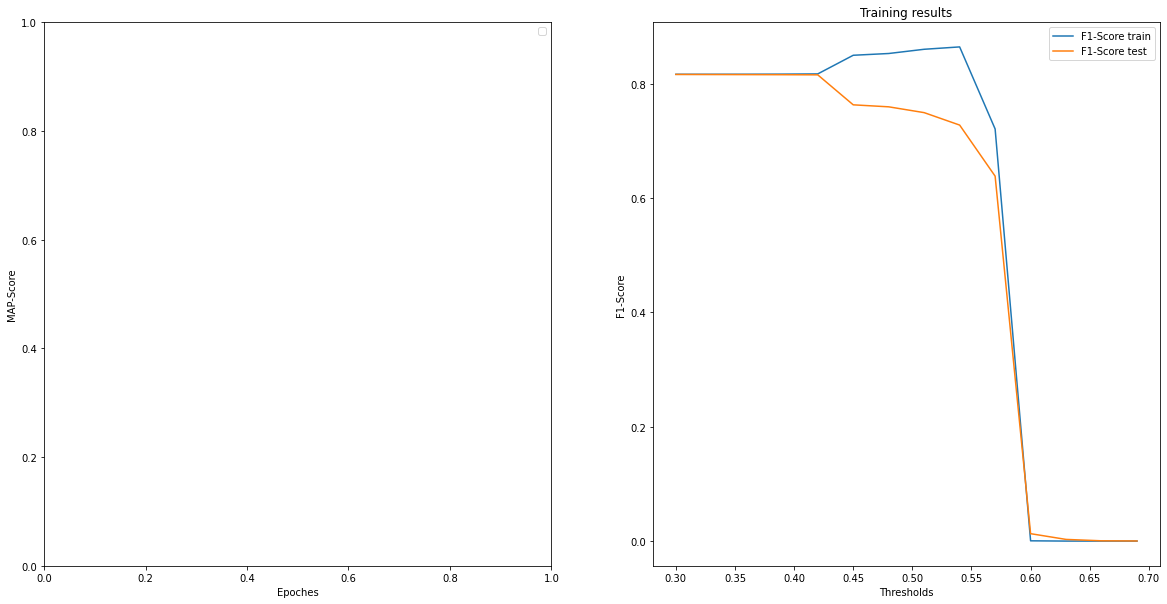

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()
ax1.set_xlabel("Epoches")
ax1.set_ylabel("MAP-Score")

ax2.plot(thresholds,Train, label='F1-Score train')
ax2.plot(thresholds,Test, label='F1-Score test')
ax2.set_xlabel("Thresholds")
ax2.set_ylabel("F1-Score")
ax2.legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [ ]:
Counter(test_set.iloc[:,-1])

Counter({0.0: 864, 1.0: 884})

In [ ]:
evaluate(test_set,0.4)

0.6659003831417625

In [ ]:
conf(test_set,0.4)

array([[  7, 857],
       [ 15, 869]])

Let's check diffrent thresholds

In [ ]:
thresholds = np.arange(0.1,0.9,0.1)
Test = [evaluate_threshold(test_set,thres) for thres in thresholds]
Train = [evaluate_threshold(train_set,thres) for thres in thresholds]

No handles with labels found to put in legend.


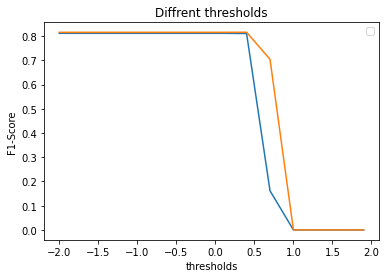

In [ ]:
plt.plot(thresholds,Test,thresholds,Train)
plt.title('Diffrent thresholds')
plt.legend()
plt.xlabel("thresholds")
plt.ylabel("F1-Score")

plt.show()

Now the same for ROC AUC

In [ ]:
evaluate_ROC_AUC(train_set)

0.988957582428156

In [ ]:
evaluate_ROC_AUC(test_set)

0.4943157417881681

Let's look at the least preferred items.

In [ ]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

,index,userId,movieId,rating
54401,54401,45,602051,0.0
662015,662015,45,53288981,0.0
54402,54402,45,602048,0.0
57611,57611,45,3145851,0.0
238,238,45,746387,0.0
1371182,1371182,45,3437466,0.0
48464,48464,45,127539479,0.0
679565,679565,45,122659790,0.0
1417710,1417710,45,132144404,0.0
273536,273536,45,10542675,0.0


Let's now look at the most likely preferences of the selected user.

In [ ]:
predictions = np.zeros((n_movies, 1))
movie_to_column_items = np.array(list(movie_to_column.items()))
df_result = pd.DataFrame(columns=['UserID', 'MovieID',  'Prediction'])

for i, movie in enumerate(movie_to_column_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Prediction
0,45,133661814,0.695394
1,45,130604714,0.649982
2,45,132123602,0.646589
3,45,132123606,0.645993
4,45,132123632,0.645602
5,45,132123624,0.645358
6,45,132123608,0.645049
7,45,132123610,0.644881
8,45,132123618,0.644733
9,45,132123616,0.644639


Now the predictions for least preferred items.

In [ ]:
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Prediction
0,45,77096691,0.341392
1,45,13851418,0.390785
2,45,7851405,0.392392
3,45,103897208,0.392392
4,45,14272842,0.392952
5,45,130559522,0.395996
6,45,80844388,0.396928
7,45,121314030,0.397807
8,45,63767374,0.397816
9,45,87544327,0.401624


I hope you enjoyed this exercise. Something you can also try on your own is to implement gradient descent instead of MAP-estimation like I did here. Let me know about any comments you may have.

In [ ]:
# Save
np.save('/content/drive/MyDrive/music_recommendation/parameters10.npy', parameters)


In [ ]:
# Load
parameters = np.load('/content/drive/MyDrive/music_recommendation/parameters10.npy',allow_pickle='TRUE').item()